# Lab 2 - Fitting Outliers, & Markov Chain Monte Carlo

We are going to work through section 3 of arxiv:1008.4686.

We'll start by importing the data in Table 1.  I grabbed the LaTeX for that table and plugged it into the *get_data()* function below, and then parse it.  You don't need to read or understand this function if you don't want to!

In [1]:
function get_data()
    # This is the copy-n-pasted LaTeX of Table 1 in 1008.4686, giving the data points we're working with.
    # \tablehead{ID &$x$ & $y$ & $\sigma_y$ & $\sigma_x$ &  \multicolumn{2}{c}{$\rho_{xy}$}}
    latex = """
1 & 201 & 592 & 61 & 9 & -0 & 84\\
2 & 244 & 401 & 25 & 4 & 0 & 31\\
3 & 47 & 583 & 38 & 11 & 0 & 64\\
4 & 287 & 402 & 15 & 7 & -0 & 27\\
5 & 203 & 495 & 21 & 5 & -0 & 33\\
6 & 58 & 173 & 15 & 9 & 0 & 67\\
8 & 202 & 504 & 14 & 4 & -0 & 05\\
9 & 198 & 510 & 30 & 11 & -0 & 84\\
10 & 158 & 416 & 16 & 7 & -0 & 69\\
11 & 165 & 393 & 14 & 5 & 0 & 30\\
12 & 201 & 442 & 25 & 5 & -0 & 46\\
13 & 157 & 317 & 52 & 5 & -0 & 03\\
14 & 131 & 311 & 16 & 6 & 0 & 50\\
15 & 166 & 400 & 34 & 6 & 0 & 73\\
16 & 160 & 337 & 31 & 5 & -0 & 52\\
17 & 186 & 423 & 42 & 9 & 0 & 90\\
18 & 125 & 334 & 26 & 8 & 0 & 40\\
19 & 218 & 533 & 16 & 6 & -0 & 78\\
20 & 146 & 344 & 22 & 5 & -0 & 56\\
"""
    # first split into lines
    lines = split(latex, '\n')
    # drop empty lines
    lines = filter(x->(length(x)>0), lines)
    # create arrays for our results
    x = zeros(length(lines))
    y = zeros(length(lines))
    yerr = zeros(length(lines))
    xerr = zeros(length(lines))
    for (i,line) in enumerate(lines)
        # Split into words separated by "&", and parse as floating-point values.
        words = split(line, "&")
        x[i] = parse(Float64, words[2])
        y[i] = parse(Float64, words[3])
        yerr[i] = parse(Float64, words[4])
        xerr[i] = parse(Float64, words[5])
    end
    return x,y,xerr,yerr
end;

Now we'll call this function once to get our dataset.

In [2]:
x,y,xerr,yerr = get_data();

Before we plot the data, let's implement the linear algebra solution from last week:

In [3]:
function weighted_least_squares(x, y, yerr)
    n = length(x)
    A = zeros(eltype(x), n, 2)
    A[:,1] .= 1.
    A[:,2] = x
    A .*= (1.0 ./ yerr)
    B = A \ (y ./ yerr)
    (b,m) = B
    return (b,m)
end;

YOUR TURN!  Make a plot of the data set (do show the y error bars; for today we're going to ignore the x error bars), and the best-fit line.

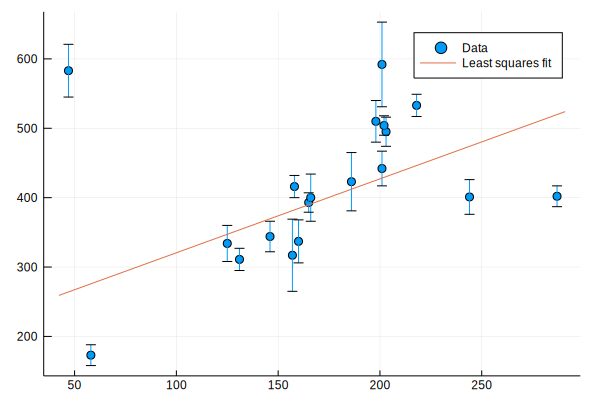

In [26]:
using Plots
gr()
b,m = weighted_least_squares(x, y, yerr);
plot(x, y, yerr=yerr, seriestype=:scatter, label="Data")
plot!(x->b+m*x, label="Least squares fit")

This doesn't look very good!  This data set, unlike the data we were working with last week, has some outliers.

By eye, you can probably see that the point in the top-left, and the two rightmost data points, could be outliers.

Before we start working on modeling the outliers, we're going to take a side trip to check out Julia's optimizer.  We'll start by writing down the data log-likelihood as we did last week:

YOUR TURN -- fill in the log-likelihood!

In [5]:
function line_log_likelihood(x, y, sigma, b, m)
    return -0.5 * sum(@. (y - (m*x + b))^2 / sigma^2)
end;

And we're going to make a "convenience" version of the function that takes a single array parameter, [b, m], and calls the *line_log_likelihood* function using our data set (with "global variables" x, y, yerr).

In [6]:
function line_lnl(bm)
    b,m = bm
    line_log_likelihood(x, y, yerr, b, m)
end;

We previously computed best-fit *b* and *m* parameters; what do you get if you call

In [7]:
line_lnl([b,m])

-143.86179566724022

You should get a value around -144

Now we're going to use Julia's *optimize* function to find these *b* and *m* as the values that optimize our log-likelihood function.

In [8]:
using Optim

In [9]:
b,m

(214.07708400199547, 1.0652097733016654)

One small annoyance: *optimize* actually wants to *minimize* a function, so we need to wrap our function with a function that returns the negative.

We have to give the *optimize* function an initial guess, and it will find a *local* optimum.  Our log-likelihood space is simple, so the initial guess doesn't have to be very good in this case.

In [10]:
func_to_minimize = x -> -line_lnl(x)
initial_guess = [0., 0.]
r = optimize(func_to_minimize, initial_guess, method=BFGS(), show_trace=true)

Iter     Function value   Gradient norm 
     0     3.823773e+03     3.309210e+03
     1     2.542936e+02     1.031729e+00
     2     1.438618e+02     1.873093e-05
     3     1.438618e+02     2.203121e-09


Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.0,0.0]
 * Minimizer: [214.07708399821348,1.0652097733221166]
 * Minimum: 1.438618e+02
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.22e-08 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 9.88e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.20e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 12
 * Gradient Calls: 12

You can get out the parameter values that optimize the function via the *r.minimizer* element.

In [11]:
r.minimizer

2-element Array{Float64,1}:
 214.07708399821348  
   1.0652097733221166

Okay, end of digression, let's work on outliers!

To start, we'll write down the log-likelihood for the data *y* in the foreground-background model.

In [12]:
function fgbg_line_log_likelihood(x, y, sigma, b, m, pbad, Y, V)
    # If the "pbad" parameter goes outside the range 0 to 1, the prior is zero, so bail out.
    if (pbad < 0) || (pbad > 1)
        return -Inf
    end

    # ADD CODE HERE -- compute the "foreground" likelihood -- evaluate the Gaussian y ~ N(b+m*x, sigma^2)
    # Note -- don't work in log space here, and do include the 1/(sqrt(2*pi)*sigma) term.
    p_fg = @. 1. / (sqrt(2. *pi) * sigma) * exp(-0.5 * (b + m*x - y)^2/(sigma^2))
    bg_var = @. sigma^2 + V
    p_bg = @. 1. / sqrt(2. *pi*bg_var) * exp(-0.5 * (y - Y)^2/bg_var)
    # Here, we weight the foreground probability by 1-pbad and the background by pbad,
    # and then take the log.
    lnl = sum(log.(
            (1. .- pbad).*p_fg .+
            pbad.*p_bg))
    # If you want to print out the inputs and outputs, you can do:
    # using Printf
    #@printf("b,m = %.3f, %.3f, pbad=%.4f, Y=%.3f, V=%.3f  --> %.3f\n", b, m, pbad, Y, V, lnl)
    return lnl
end;

As before, we'll define a "convenience" version:

In [13]:
function fgbg_line_lnl(params)
    return fgbg_line_log_likelihood(x, y, yerr, params...)
end;

To test, make sure your function returns these values:

In [14]:
fgbg_line_lnl([b, m, 0., 0., 1.])

-221.96394057665086

In [15]:
using Statistics
fgbg_line_lnl([b, m, 0.1, mean(y), var(y)])

-125.90876697361364

Above, note that even when we set *pbad = 0*, we get a different log-likelihood than the -144 value we got before -- can you think why that is?

Now we can call the optimizer on our foreground-background model!

In [16]:
initial = [b, m, 0.1, mean(y), var(y)]
r = optimize(x-> -fgbg_line_lnl(x), initial, method=BFGS(), show_trace=true)

Iter     Function value   Gradient norm 
     0     1.259088e+02     6.747229e+01
     1     1.138622e+02     2.696081e+00
     2     1.136420e+02     6.355005e-01
     3     1.136294e+02     6.519426e-01
     4     1.136289e+02     5.000892e-01
     5     1.136218e+02     1.263714e-01
     6     1.135932e+02     1.893217e+00
     7     1.133853e+02     3.906282e+00
     8     1.130306e+02     8.112558e+00
     9     1.126896e+02     2.037480e+00
    10     1.126782e+02     2.828139e-01
    11     1.126780e+02     3.694496e-03
    12     1.126780e+02     6.609326e-02
    13     1.126725e+02     1.383278e-01
    14     1.126725e+02     6.615402e-04
    15     1.126725e+02     1.171163e-05
    16     1.126725e+02     2.422153e-04
    17     1.126724e+02     1.127917e-01
    18     1.126715e+02     6.190471e-03
    19     1.126715e+02     7.425465e-05
    20     1.126715e+02     8.917786e-08
    21     1.126715e+02     2.689925e-12


Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [214.07708400199547,1.0652097733016654, ...]
 * Minimizer: [255.61974100194777,0.5286310788014387, ...]
 * Minimum: 1.126715e+02
 * Iterations: 21
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 4.74e-05 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.69e-12 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 80
 * Gradient Calls: 80

Here are the params that optimize the function:

In [17]:
p1 = r.minimizer

5-element Array{Float64,1}:
   255.61974100194777  
     0.5286310788014387
     0.7308654873052074
   436.2177231202161   
 10659.259127207328    

Let's pull out the b,m terms and plot them:

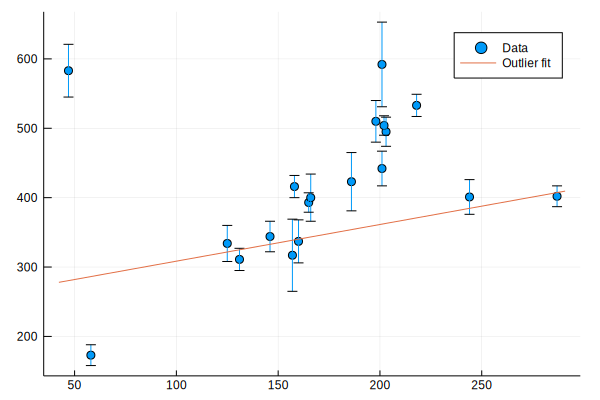

In [18]:
bx,mx = r.minimizer[1:2]
plot(x, y, yerr=yerr, seriestype=:scatter, label="Data")
plot!(x->bx+mx*x, label="Outlier fit")

Does this make you happy?

Remember how I said the optimizer finds a *local* minimum?  Can you try initializing it in a part of parameter space that looks about right?

In [19]:
initial2 = [100., 2., 0.1, mean(y), var(y)]
r2 = optimize(x-> -fgbg_line_lnl(x), initial2, method=BFGS());
p2 = r2.minimizer
b2,m2 = p2[1:2]

2-element Array{Float64,1}:
 29.647526090248284
  2.281084179435903

And just for kicks, here's another initialization:

In [20]:
initial3 = [650, -1., 0.9, mean(y), var(y)]
r3 = optimize(x-> -fgbg_line_lnl(x), initial3, method=BFGS());
p3 = r3.minimizer
b3,m3 = p3[1:2]

2-element Array{Float64,1}:
 663.9097316841026 
  -0.85458177557509

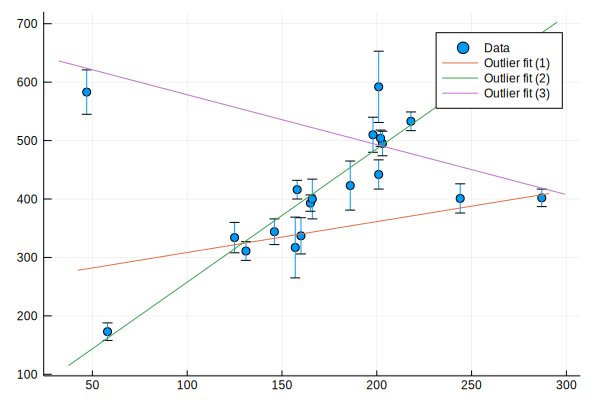

In [21]:
plot(x, y, yerr=yerr, seriestype=:scatter, label="Data")
plot!(x->bx+mx*x, label="Outlier fit (1)")
plot!(x->b2+m2*x, label="Outlier fit (2)")
plot!(x->b3+m3*x, label="Outlier fit (3)")

Let's look at what the likelihood looks like for a given $x$ value (100) and $sigma$.

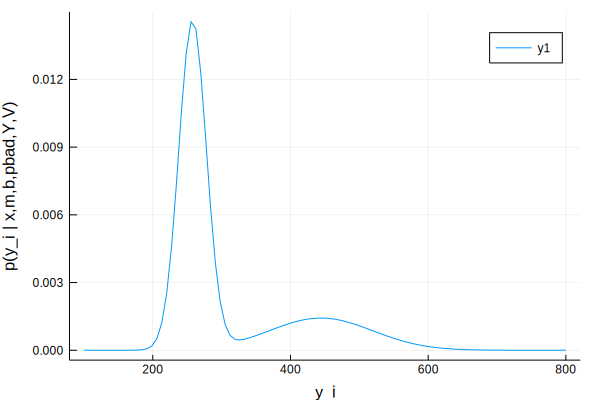

In [22]:
yy = range(100, stop=800, length=100)
plot(yy, y->exp(fgbg_line_log_likelihood(100., y, 20., p2...)), xlabel="y_i", ylabel="p(y_i | x,m,b,pbad,Y,V)")

You can see that this is composed of two Gaussian components.  The narrow peak (centered on y=mx+b for x=100) is the foreground model.  The broad peak corresponds to the background model.

Imagine that you have a data point here at x=100 and with y=220, partway up the large peak.  This data point is very sensitive to the parameters of the foreground model, and hardly sensitive at all to the parameters of the background model.  If you look at the heights of the foreground and background models at that point, you will see that this data point is mostly "explained" by the foreground model.

Now consider a data point at x=100 and y=600, on the right-hand side of the background distribution.  This data point hardly cares at all about the parameters of the foreground model; most of its likelihood comes from the background distribution.  Therefore, this data point would be called an outlier and it would have barely any effect on the fitting of the foreground model parameters.

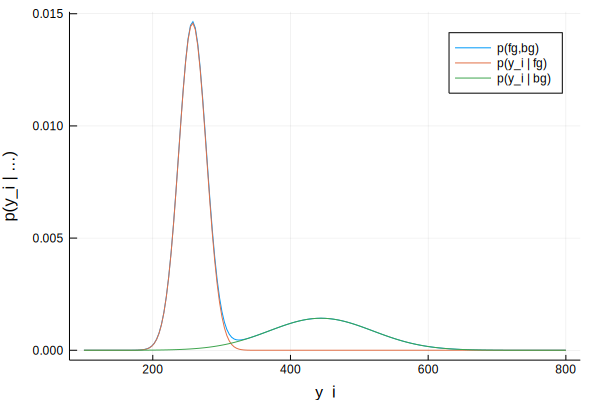

In [23]:
# Plot the foreground and background model components separately by tweaking "p2" parameter "pbad"
p2fg = copy(p2)
p2fg[3] = 0.
p2bg = copy(p2)
p2bg[3] = 1.
yy = range(100, stop=800, length=200)
plot(yy, y->exp(fgbg_line_log_likelihood(100., y, 20., p2...)), xlabel="y_i", ylabel="p(y_i | ...)",
    label="p(fg,bg)")
plot!(yy, y->(1-p2[3])*exp(fgbg_line_log_likelihood(100., y, 20., p2fg...)), xlabel="y_i", label="p(y_i | fg)")
plot!(yy, y->p2[3]*exp(fgbg_line_log_likelihood(100., y, 20., p2bg...)), xlabel="y_i", label="p(y_i | bg)")

Now, one issue we saw with this foreground-background model was that depending on how we initialized the optimizer, we got different results.  In Lab 1, we mapped out a (much simpler) likelihood space by evaluating the likelihood on a grid.  But our foreground-background model has 5 parameters -- evaluating that on a grid is going to be difficult, and visualizing the results even tougher!

To build intuition, let's nail down the background part of the model -- fix pbad=10%, and the background Gaussian N(Y,V) to be the mean and variance of all the data points (foreground and background).  Then we are left with just m and b, and we can map out the likelihood.

In [24]:
using Plots
gr()

Plots.GRBackend()

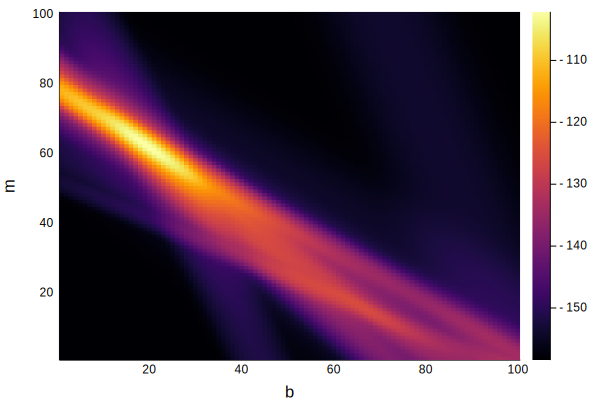

In [25]:
Y = mean(y)
V = var(y)
pbad = 0.1

blo,bhi = -100., 600.
mlo,mhi = -0.5, 4.
bb = range(blo, stop=bhi, length=100)
mm = range(mlo, stop=mhi, length=100)
LL = zeros((length(mm), length(bb)))
for i in 1:length(mm)
    for j in 1:length(bb)
        LL[i, j] = fgbg_line_log_likelihood(x, y, yerr, bb[j], mm[i], pbad, Y, V)
    end
end
heatmap(LL, xlabel="b", ylabel="m")#, xlim=[blo,bhi], ylim=[mlo,mhi], aspect_ratio=(bhi-blo)/(mhi-mlo))

You can see different ellipses, corresponding to different combinations of m,b that hit different subsets of the data points.

In lecture 3 we are going to learn the Markov Chain Monte Carlo algorithm, which is useful for exploring likelihood spaces like this.